In [1]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [341]:
from pathlib import Path
import os
import re
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
import pandas as pd
import geopandas as geopd
import networkx as nx
from infomap import Infomap
import community
import ray
import libpysal
import esda
from sklearn.decomposition import PCA
import sklearn.cluster
import scipy.cluster.hierarchy as shc
import src.data.bin as data_bin
import src.data.read as read_data
import src.data.clustering as data_clustering
import src.data.word_counts as word_counts
import src.utils.paths as paths_utils
import src.utils.parallel as parallel
import src.utils.geometry as geo
import src.utils.dialects as dialects
import src.visualization.maps as map_viz
import src.visualization.interactive as interact_viz
import src.visualization.eval as eval_viz
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
paths = paths_utils.ProjectPaths()
with open(paths.ext_data / 'countries.json') as f:
    countries_dict = json.load(f)
all_cntr_shapes = geopd.read_file(paths.ext_data / 'CNTR_RG_01M_2016_4326.shp' / 'CNTR_RG_01M_2016_4326.shp')

TODO: 

only UK, GB + IE

NZ + AU

US + CA

# Load regions data

In [342]:
list_cc = ['GB', 'IE'] # ['CA', 'GB', 'AU', 'ZA', 'NG', 'IN', 'IE', 'NZ', 'JM', 'BZ', 'US']
eng_uk = dialects.Language.from_countries_dict(
    'en', 'English', list_cc, countries_dict, all_cntr_shapes, paths,
    min_nr_cells=10, cell_tokens_th=1e5)

In [343]:
lang = eng_uk

In [5]:
list_cc = ('IE', 'GB', 'NZ')
data_dict = {cc: countries_dict[cc] for cc in list_cc}

In [6]:
for cc, reg_dict in data_dict.items():
    cell_size = reg_dict.get('cell_size', 50e3)
    xy_proj = reg_dict['xy_proj']
    shapefile_dict = {**{'col': 'FID', 'val': cc, 'cc': cc},
                      **reg_dict.get('shapefile_dict', {})}
    shape_df = all_cntr_shapes.loc[all_cntr_shapes[shapefile_dict['col']] == shapefile_dict['val']]
    shape_df = geo.extract_shape(shape_df, cc, xy_proj=xy_proj, simplify_tol=1000)
    reg_dict['shape_df'] = shape_df
    _, cells_geodf, _, _ = geo.create_grid(shape_df, cell_size, xy_proj=xy_proj, intersect=True)
    reg_dict['cells_geodf'] = cells_geodf
    for df_name in ['cell_counts', 'region_counts', 'raw_cell_counts']:
        reg_dict[df_name] = pd.read_parquet(proj_data_path / 'raw' / fname_fmt.format(df_name, cc))

In [57]:
cc = 'US'
xy_proj = data_dict[cc]['xy_proj']
shapefile_dict = {'col': 'FID', 'val': cc, 'cc': cc}
shape_df = geopd.read_file(ext_data_path / 'CNTR_RG_01M_2016_4326.shp' / 'CNTR_RG_01M_2016_4326.shp')
shape_df = all_cntr_shapes.loc[all_cntr_shapes[shapefile_dict['col']] == shapefile_dict['val']]
shape_df = geo.extract_shape(shape_df, cc, bbox=data_dict[cc].get('bbox'), xy_proj=xy_proj, simplify_tol=100)
data_dict[cc]['shape_df'] = shape_df
cells_geodf = geopd.read_file(str(shp_file_format).format('cb_2018_us_county_5m'))
# us_counties = us_counties.astype({'GEOID': int, 'STATEFP': int})
# Exclude all overseas islands and Alaska
# to_exclude = (us_counties['STATEFP'].isin((15, 2))) | (us_counties['STATEFP'] > 56)
# us_counties = us_counties.loc[~to_exclude]
cells_geodf = (
    cells_geodf.rename(columns={'GEOID': 'cell_id'})[['cell_id', 'geometry']]
               .astype({'cell_id': int})
               .sort_values(by='cell_id')
               .set_index('cell_id', drop=False))
cells_geodf.index  = cc + '.' + cells_geodf.index.astype(str)
data_dict[cc]['cells_geodf'] = cells_geodf
for df_name, name_in_file in [('region_counts', 'old_region_counts'),
                              ('raw_cell_counts', 'old_raw_cell_counts')]:
    data_dict[cc][df_name] = pd.read_parquet(proj_data_path / 'raw' / fname_fmt.format(name_in_file, cc))

# Merge to global

min_nr_cells in function of min_nr_cells_reg, to calculate on raw_cell_counts index?

In [7]:
global_counts = lang.get_global_counts()

In [8]:
global_counts = lang.filter_global_counts()

In [9]:
raw_cell_counts = lang.get_raw_cell_counts()

In [318]:
lang.cell_tokens_th = 1e5

In [319]:
cell_counts = lang.get_cell_counts()

Keeping 176 cells out of 197 with threshold 1.00e+05
We had 4579899648 tokens, and filtering  brought it down to 3934769055, so we lost  14.1%.


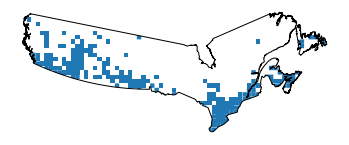

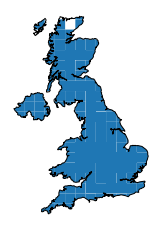

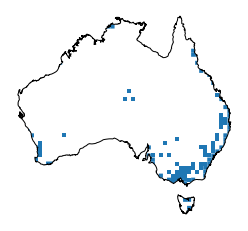

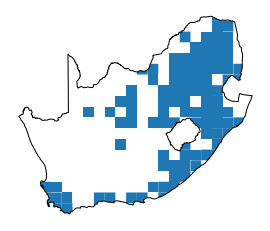

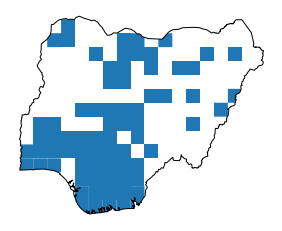

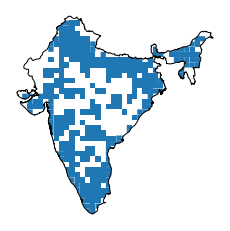

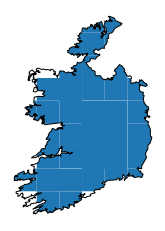

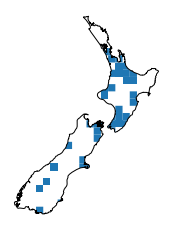

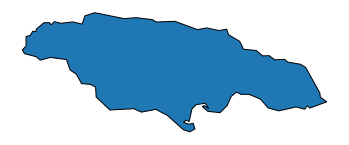

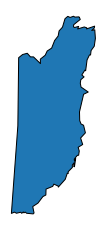

In [24]:
plot_geodf = lang.cells_geodf.loc[lang.relevant_cells]
for reg in lang.regions:
    fig, ax = plt.subplots(1)
    xy_proj = reg.xy_proj
    cc_idx = plot_geodf.index.str.startswith(reg.cc)
    cc_geodf = plot_geodf.loc[cc_idx].to_crs(xy_proj)
    cc_geodf.plot(ax=ax)
    reg.shape_geodf.plot(ax=ax, color='none', edgecolor='k')
    ax.set_axis_off()
    fig.show()

In [15]:
width_ratios = lang.get_width_ratios(ratio_lgd=0.05)

In [321]:
word_counts_vectors = lang.get_word_counts_vectors()

In [322]:
lang.set_word_vec_var('polar')

In [323]:
word_vectors = lang.get_word_vectors()

In [324]:
lang.word_vectors.shape

(176, 18852)

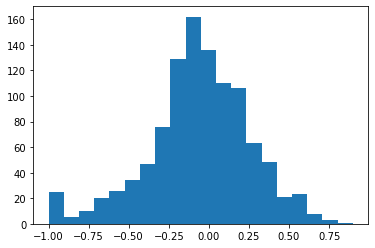

In [128]:
iloc_word = list(lang.global_counts['cdf_mask'].loc[lang.global_counts['cdf_mask']].index).index('nigga')
fig, ax = plt.subplots(1)
_, _, patches = ax.hist(lang.word_vectors[:, iloc_word], bins=20)

# Moran 

does it change much if done on proportions/counts directly?? because here we don't compare words with one another, but the same word in space, which implies we'll have similar scales

TODO: handle different xy_proj for Moran if distance based contiguity, 3857 because anyway far apart cells will have huge distance so no influence over one another? and 3857 not so bad locally

In [327]:
global_counts = lang.calc_morans(num_cpus=8)

/home/thomaslouf/Documents/code/words-use/.cenv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 108.



('WARNING: ', 108, ' is an island (no neighbors)')


2021-05-05 16:11:28,120	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


In [328]:
lang.save_interim()

In [344]:
lang.load_interim()

In [345]:
lang.filter_word_vectors(z_th=20, p_th=0.005)

Keeping 0 words out of 18852


In [195]:
# relevant_cells = cell_counts.index.levels[cell_counts.index.names.index('cell_id')]
# cell_counts.index = cell_counts.index.set_levels(cells_geodf.loc[cells_geodf['cell_id'].isin(relevant_cells)].index, level='cell_id')
relevant_cells = cell_counts.index.levels[cell_counts.index.names.index('cell_id')]
relevant_cells = relevant_cells.str.replace('UK', 'GB')
contiguity = libpysal.weights.Queen.from_dataframe(cells_geodf.loc[relevant_cells])
contiguity.transform = 'r'

/home/thomaslouf/Documents/code/words-use/.cenv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 6 disconnected components.



In [22]:
num_cpus = 8
ray.init(num_cpus=num_cpus)
num_morans = lang.word_vectors.shape[1]
shared_word_vectors = ray.put(lang.word_vectors)
obj_refs = parallel.split_task(data_clustering.chunk_moran, num_cpus,
                               list(range(num_morans)), shared_word_vectors, contiguity)
res = ray.get(obj_refs)
moran_dict = res[0]
for m_dict in res[1:]:
    for key, value in m_dict.items():
        moran_dict[key].extend(value)
ray.shutdown()

2021-04-13 10:46:45,786	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


In [23]:
lang.global_counts = lang.global_counts.join(pd.DataFrame.from_dict(moran_dict).set_index(lang.global_counts.loc[lang.global_counts['cdf_mask']].index[:num_morans]))

# PCA

In [189]:
decomps = lang.decompositions

In [23]:
decomposition = lang.make_decomposition(n_components=20)

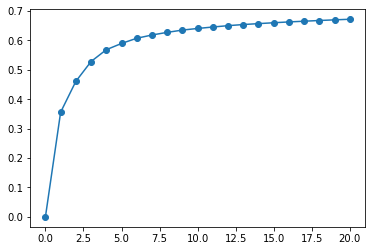

In [24]:
fig, ax = decomposition.explained_var_plot()

In [60]:
decomposition.decomposition.components_[0].shape

(4129,)

In [30]:
is_regional = ((lang.global_counts['z_value'] > lang.z_th)
              & (lang.global_counts['p_value'] < lang.p_th))
a = lang.global_counts.loc[is_regional].copy()
i_comp = 0
a[f'comp{i_comp}_load'] = decomposition.decomposition.components_[i_comp]
a.sort_values(by=f'comp{i_comp}_load', key=np.abs, ascending=False).head(20)

,count,is_proper,nr_cells,I,z_value,p_value,cdf_mask,comp0_load
word,,,,,,,,
crore,110054.0,0.0,654.959972,1.012907,44.361407,0.001,True,0.043712
lakh,91236.0,0.0,650.677872,1.013164,43.919454,0.001,True,0.043663
rupees,27984.0,0.0,652.528287,0.999763,42.069054,0.001,True,0.043248
crores,65295.0,0.0,588.794336,1.010227,44.517461,0.001,True,0.043167
needful,34983.0,0.0,713.808577,0.962742,40.647315,0.001,True,0.042352
caste,68296.0,0.0,758.984118,0.997013,44.508197,0.001,True,0.041501
bhi,219342.0,0.0,762.215323,0.990518,42.331164,0.001,True,0.040793
raha,56178.0,0.0,637.124241,0.971633,41.545353,0.001,True,0.040632
liye,67837.0,0.0,605.634044,0.982095,40.457179,0.001,True,0.040256


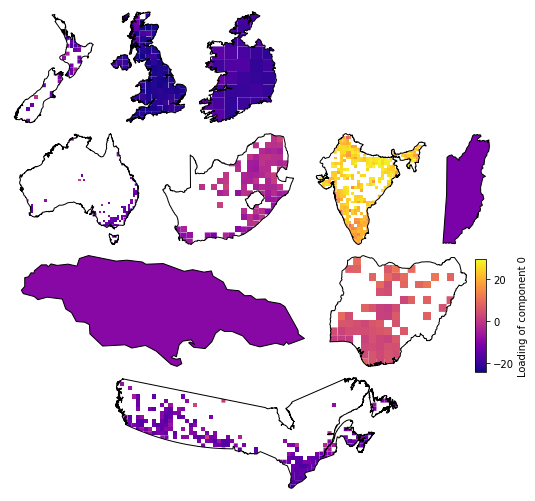

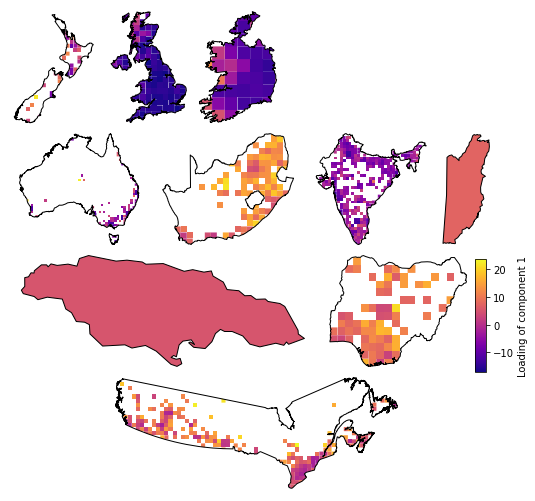

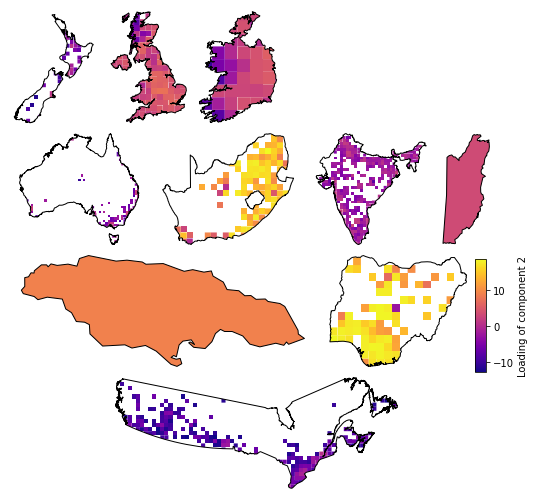

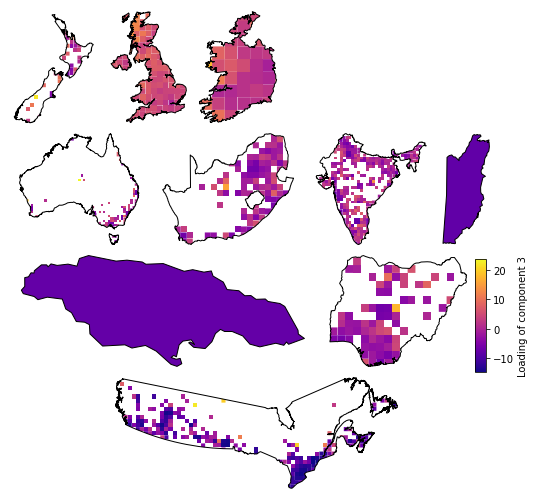

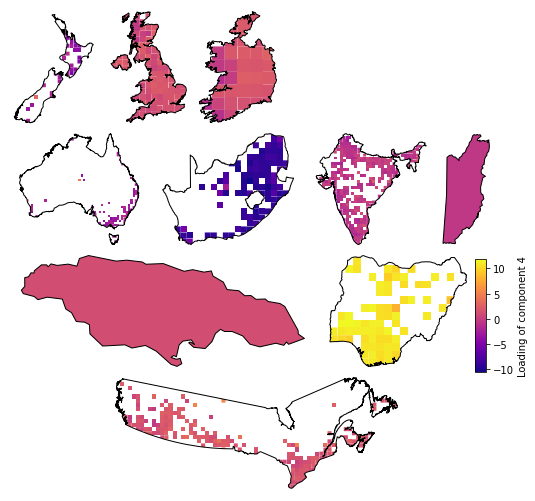

In [28]:
lang.map_comp_loading(nr_plots=5)

In [211]:
n_components = 20

In [212]:
pca = PCA(n_components=n_components)
pca.fit(reg_word_vectors)

PCA(n_components=20)

In [213]:
proj_vectors = pca.transform(reg_word_vectors)

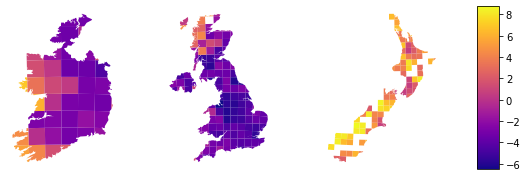

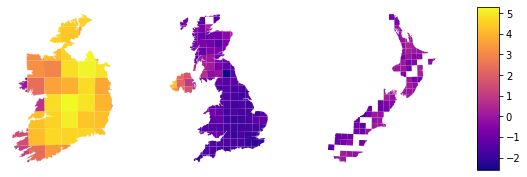

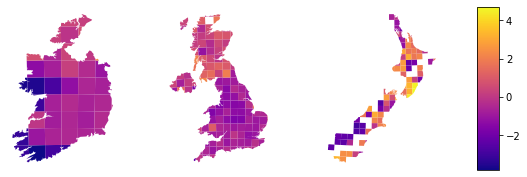

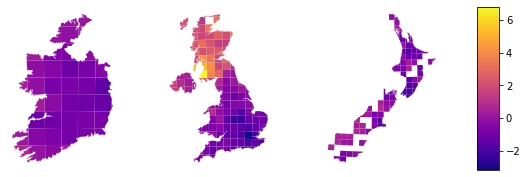

In [243]:
cmap = 'plasma'
for i in range(4):
    comp_series = pd.Series(proj_vectors[:, i], index=relevant_cells, name='pca_comp')
    fig, axes = plt.subplots(ncols=len(list_cc)+1, figsize=(9,3),
                             gridspec_kw={'width_ratios': width_ratios})
    map_axes = axes[:-1]
    cax = axes[-1]
    vmin = proj_vectors[:, i].min()
    vmax = proj_vectors[:, i].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    for ax, cc in zip(map_axes, data_dict.keys()):
        plot_df = (cells_geodf.loc[cells_geodf.index.str.startswith(cc)]
                              .join(comp_series, how='inner'))
        plot_df.plot(column='pca_comp', ax=ax, norm=norm, cmap=cmap)
        ax.set_axis_off()

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cax, label='')
    fig.show()

# Clustering

In [362]:
# eng_no_US = dialects.Language(**{**dataclasses.asdict(eng),
#                                  **{'regions': eng.regions, 'decompositions': eng.decompositions, 'paths': paths}},
#                               all_cntr_shapes=all_cntr_shapes)
lang = eng_no_US

In [167]:
clusts = lang.decompositions[-1].clusterings

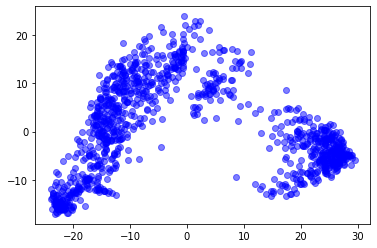

In [190]:
proj_vectors = lang.decompositions[-1].proj_vectors
plt.scatter(proj_vectors[:, 0], proj_vectors[:, 1], c='b', alpha=0.5)

## Agglo

In [210]:
lang.decompositions[-1].clusterings = []

In [34]:
# agg_clustering_params = {'metric': 'cosine', 'method': 'average'}
agg_clustering_params = {'metric': 'euclidean', 'method': 'ward'}
max_n_clusters = 9
clustering = lang.decompositions[-1].add_scipy_hierarchy(
    lang.relevant_cells, max_n_clusters=max_n_clusters,
    **agg_clustering_params)

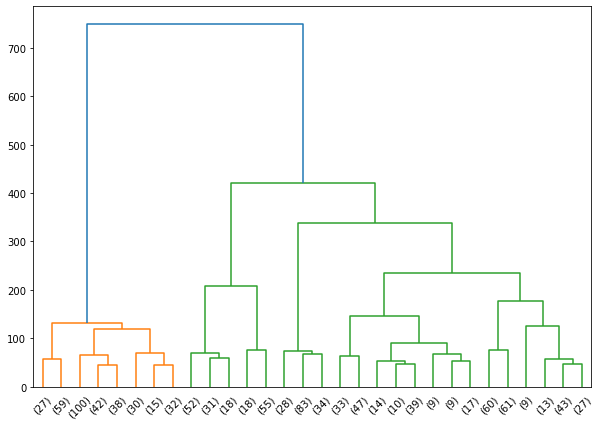

In [36]:
fig, ax = clustering.plot_dendogram(p=30)

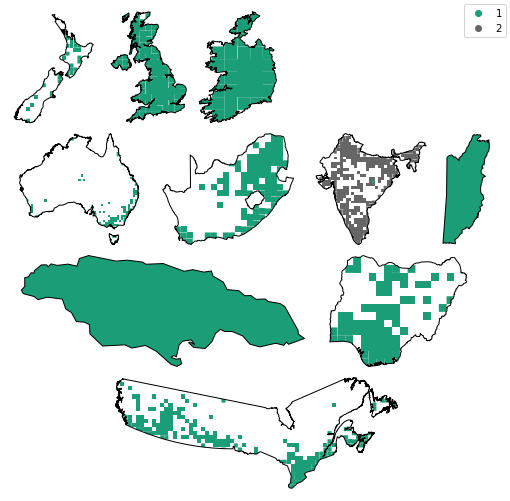

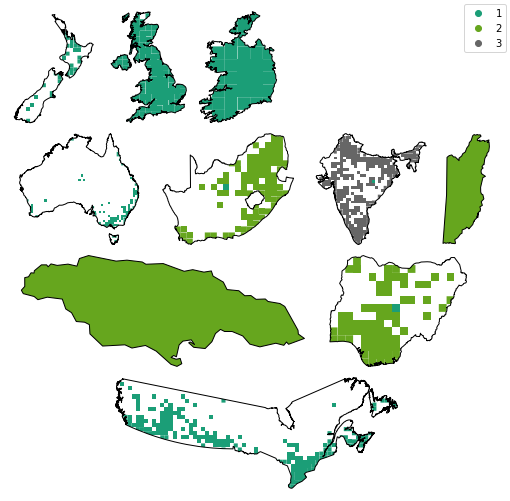

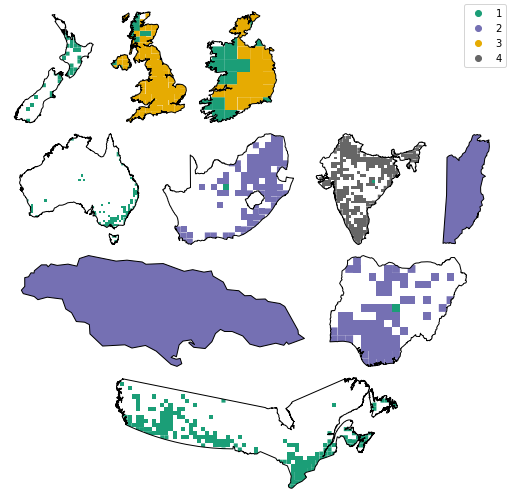

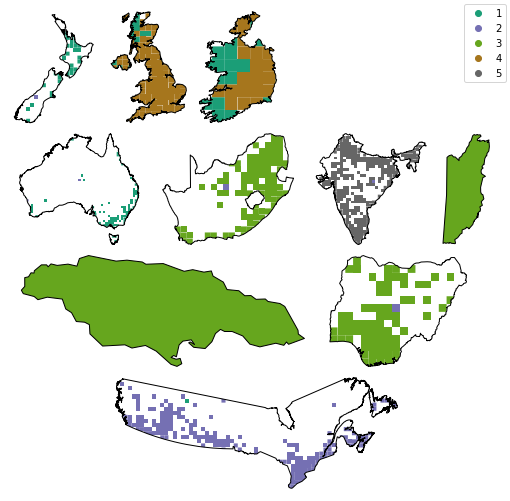

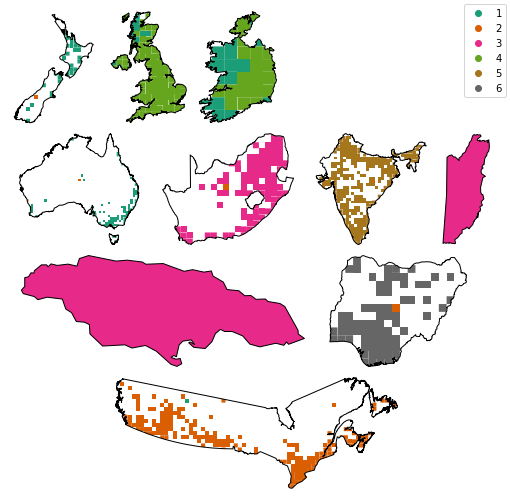

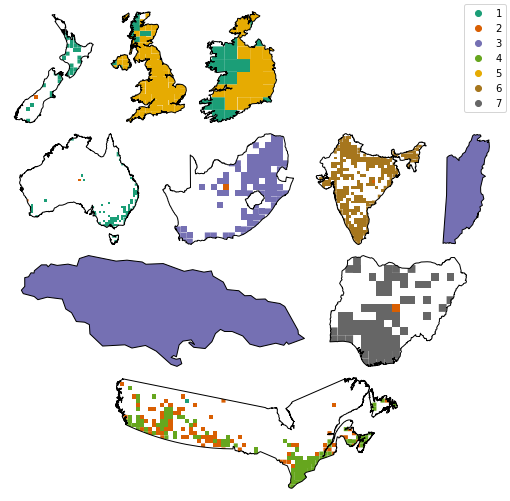

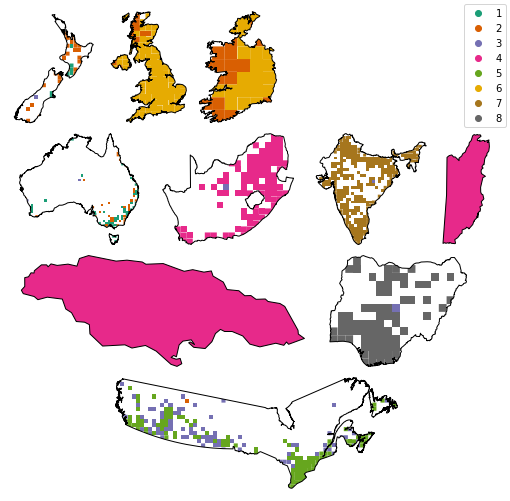

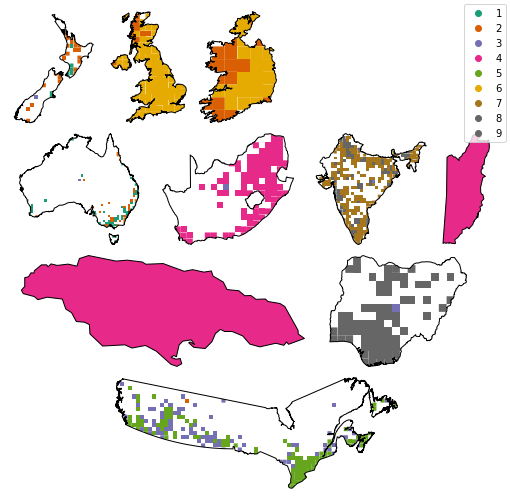

In [37]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1, cmap='Dark2',
                               save_path_fmt=paths.cluster_fig_fmt)

For n_clusters = 2, the average silhouette_score is 0.4410687673304613, and considering noise as singletons:  0.4410687673304613
For n_clusters = 3, the average silhouette_score is 0.4308732279300016, and considering noise as singletons:  0.4308732279300016
For n_clusters = 4, the average silhouette_score is 0.4316370284235672, and considering noise as singletons:  0.4316370284235672
For n_clusters = 5, the average silhouette_score is 0.43869189480332355, and considering noise as singletons:  0.43869189480332355
For n_clusters = 6, the average silhouette_score is 0.4537315791426335, and considering noise as singletons:  0.4537315791426335
For n_clusters = 7, the average silhouette_score is 0.4505403264222794, and considering noise as singletons:  0.4505403264222794
For n_clusters = 8, the average silhouette_score is 0.45319322341171847, and considering noise as singletons:  0.45319322341171847


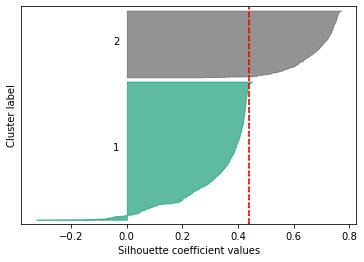

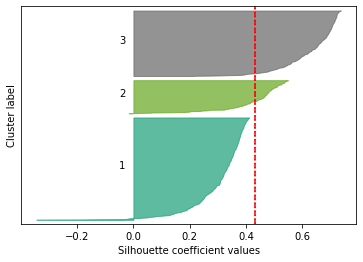

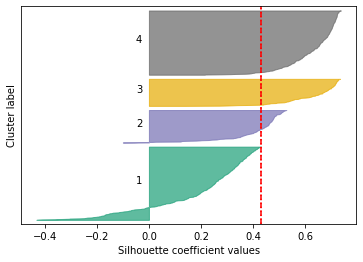

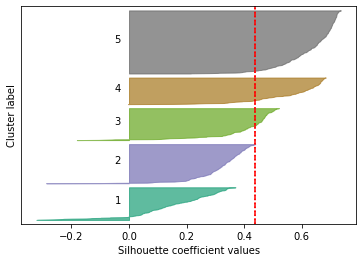

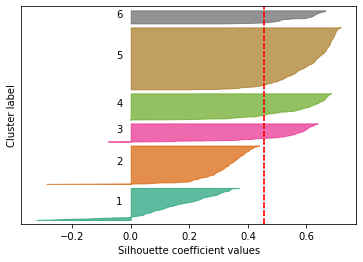

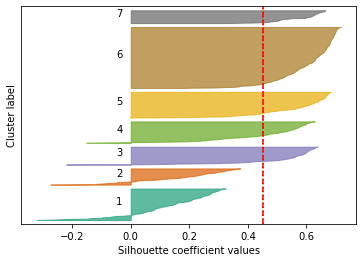

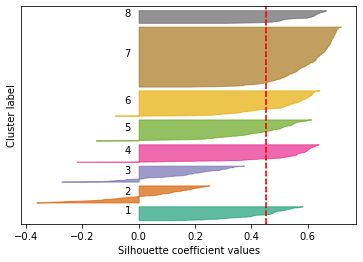

In [188]:
clustering.silhouette_plot(lang.decompositions[-1].proj_vectors)

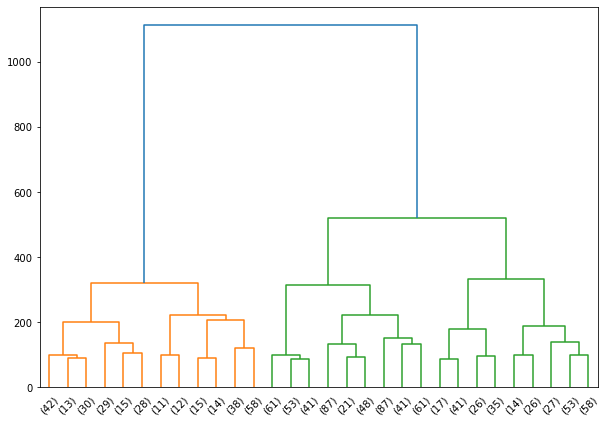

In [42]:
# agg_clustering_params = {'metric': 'cosine', 'method': 'average'}
agg_clustering_params = {'metric': 'euclidean', 'method': 'ward'}
linkage = shc.linkage(proj_vectors, **agg_clustering_params)
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(linkage, p=30, truncate_mode='lastp')

In [40]:
max_nr_clusters = 5
nr_clusters_arr = np.asarray(range(2, max_nr_clusters + 1))
cutree = shc.cut_tree(linkage, n_clusters=nr_clusters_arr)

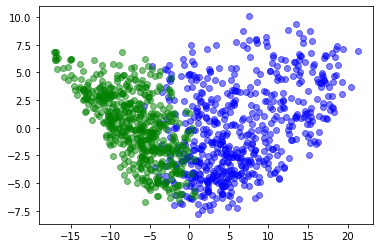

In [222]:
hierarc_clust = cutree[:, 0]
plt.scatter(proj_vectors[hierarc_clust==0, 0], proj_vectors[hierarc_clust==0, 1], c='b', alpha=0.5)
plt.scatter(proj_vectors[hierarc_clust==1, 0], proj_vectors[hierarc_clust==1, 1], c='g', alpha=0.5)

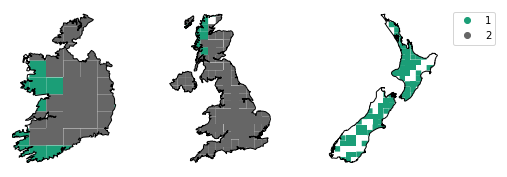

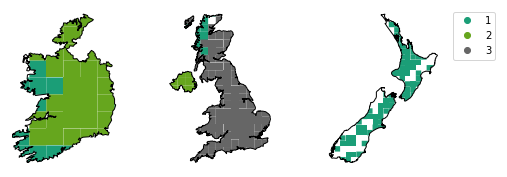

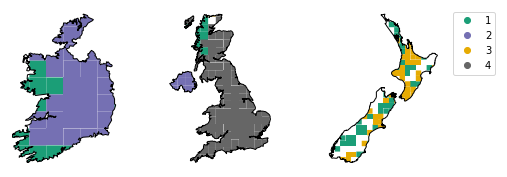

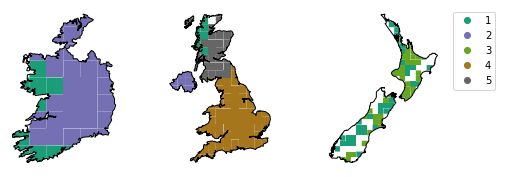

In [248]:
cmap = 'Dark2'
for i, n_clusters in enumerate(nr_clusters_arr):
    fig, axes = map_viz.joint_cc(
        cells_geodf.loc[relevant_cells], cutree[:, i], data_dict, cmap=cmap, show=True,
        figsize=(9,3), gridspec_kw={'width_ratios': width_ratios})

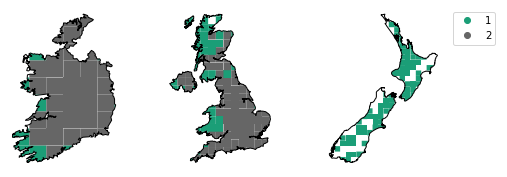

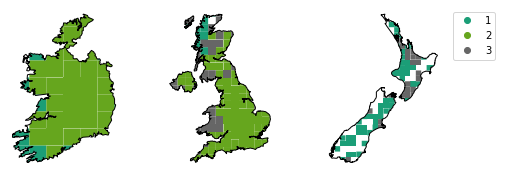

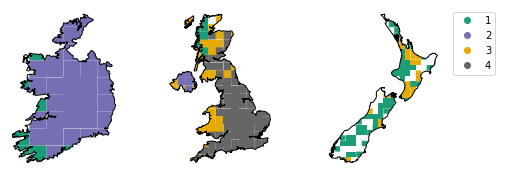

In [226]:
cmap = 'Dark2'
for i, n_clusters in enumerate(nr_clusters_arr):
    fig, axes = map_viz.joint_cc(
        cells_geodf.loc[relevant_cells], cutree[:, i], data_dict, cmap=cmap, show=True,
        figsize=(9,3), gridspec_kw={'width_ratios': width_ratios})

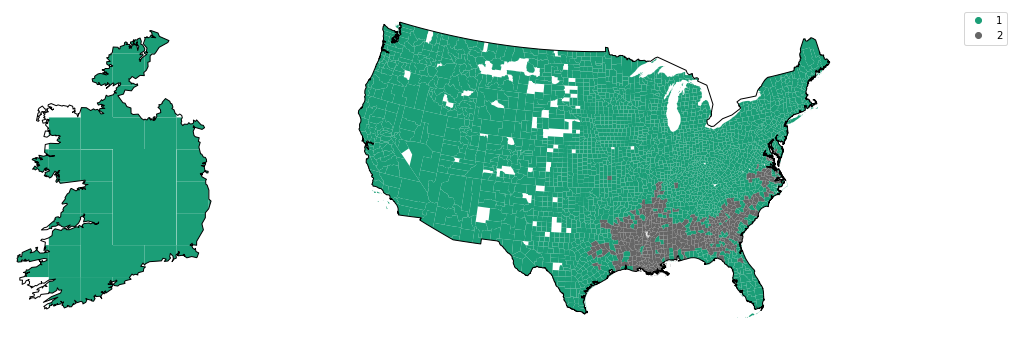

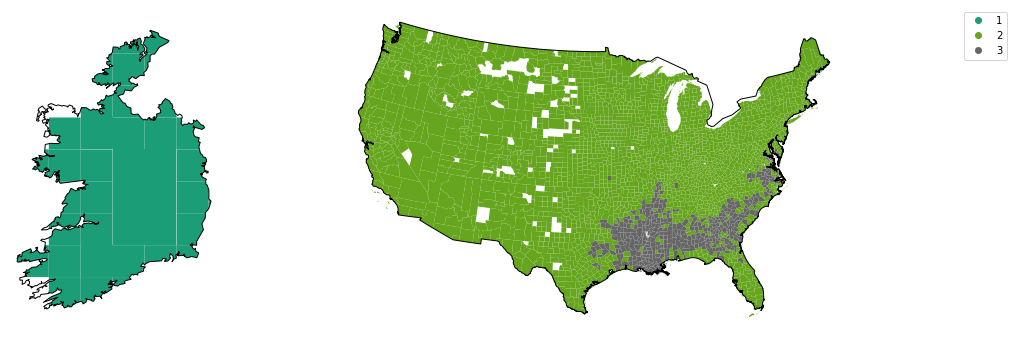

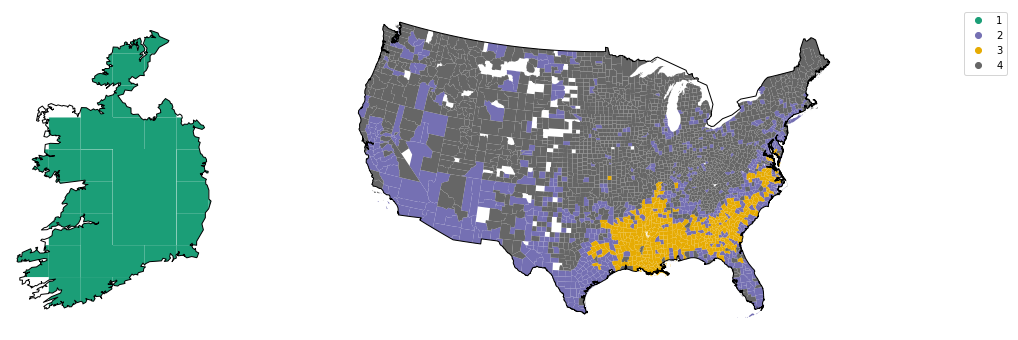

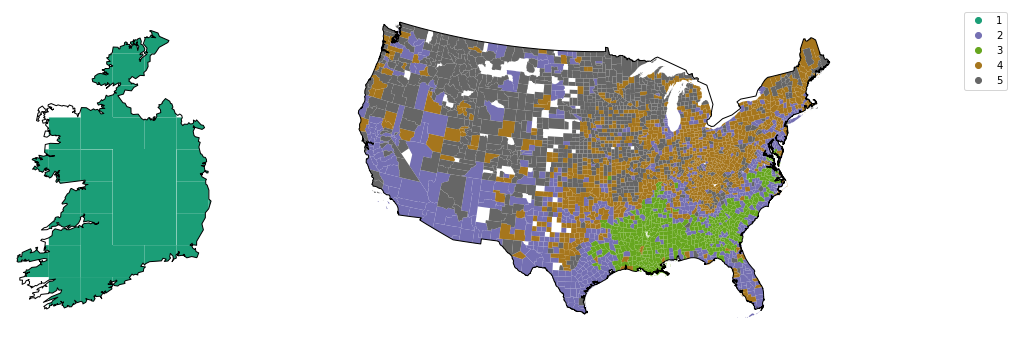

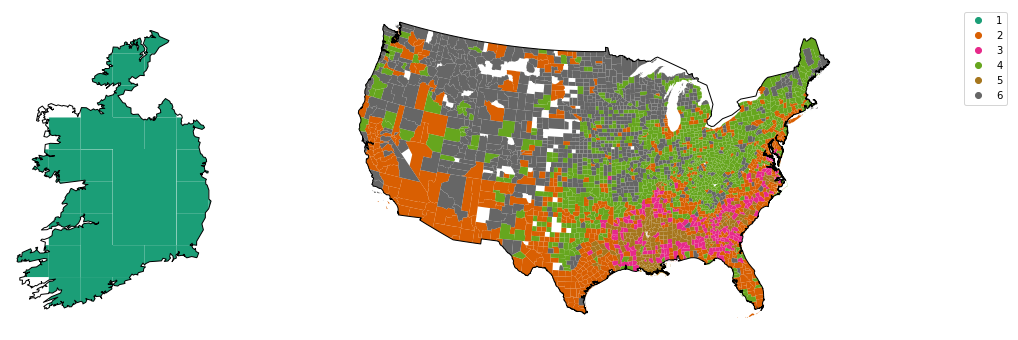

In [378]:
cmap = 'Dark2'
for i, n_clusters in enumerate(nr_clusters_arr):
    fig, axes = map_viz.joint_cc(
        cells_geodf.loc[relevant_cells], cutree[:, i], data_dict, cmap=cmap, show=True,
        figsize=(18,6), gridspec_kw={'width_ratios': width_ratios})

## GMM

In [38]:
import sklearn.mixture

In [147]:
kwargs = {'n_components': 3, 'covariance_type': 'full'}
method = sklearn.mixture.BayesianGaussianMixture
clustering = lang.decompositions[-1].add_clustering(
    method, lang.relevant_cells, **kwargs)

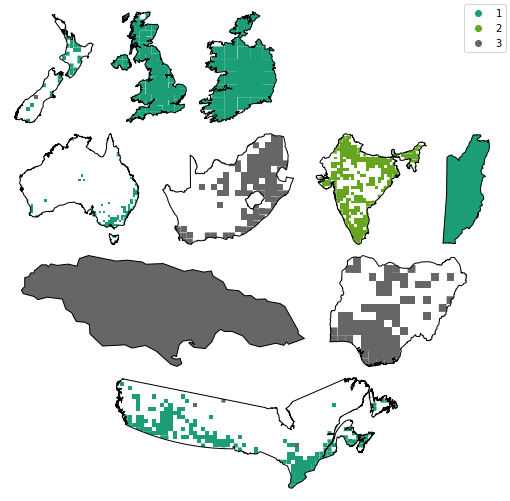

In [46]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1, cmap='Dark2',
                               save_path_fmt=paths.cluster_fig_fmt)

For n_clusters = 3, the average silhouette_score is 0.384653899772868, and considering noise as singletons:  0.384653899772868


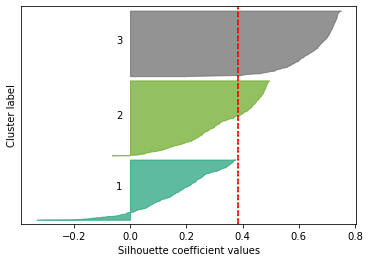

In [165]:
fig, ax = clustering.silhouette_plot(lang.decompositions[-1].proj_vectors)

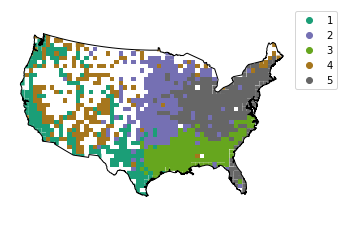

In [92]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1, cmap='Dark2')

In [31]:
n_components = 5
dpgmm = sklearn.mixture.BayesianGaussianMixture(
    n_components=n_components, covariance_type='full').fit(lang.decompositions[-1].proj_vectors)
dpgmm_res = dpgmm.predict(lang.decompositions[-1].proj_vectors)

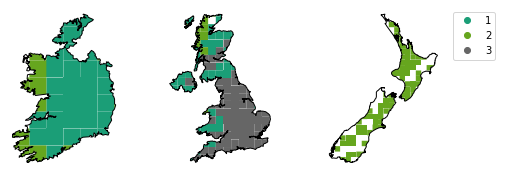

In [232]:
cmap = 'Dark2'
fig, axes = map_viz.joint_cc(
    cells_geodf.loc[relevant_cells], dpgmm_res, data_dict, cmap=cmap, show=True,
    figsize=(9,3), gridspec_kw={'width_ratios': width_ratios})

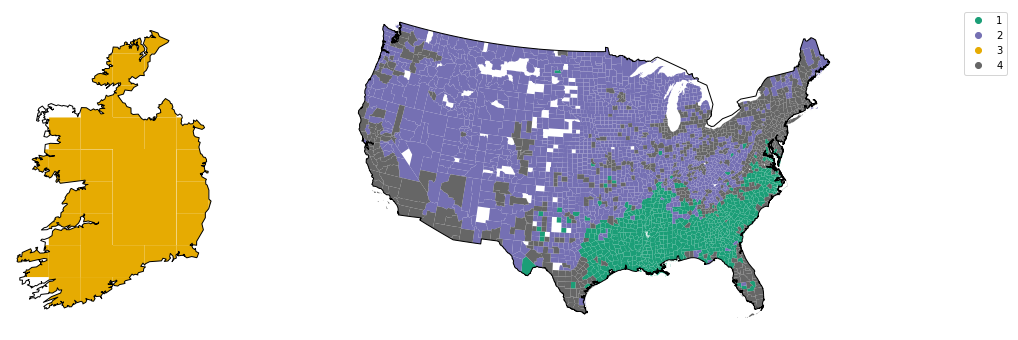

In [393]:
cmap = 'Dark2'
fig, axes = map_viz.joint_cc(
    cells_geodf.loc[relevant_cells], dpgmm_res, data_dict, cmap=cmap, show=True,
    figsize=(18,6), gridspec_kw={'width_ratios': width_ratios})

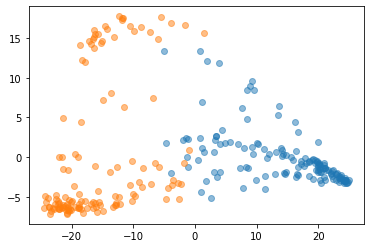

In [230]:
hierarc_clust = dpgmm_res
for i in range(n_components):
    plt.scatter(proj_vectors[hierarc_clust==i, 0], proj_vectors[hierarc_clust==i, 1], alpha=0.5)

## DBSCAN / OPTICS

In [125]:
dbscan_params = {'eps': 4, 'min_samples': 10, 'metric': 'euclidean'}
method = sklearn.cluster.DBSCAN
clustering = lang.decompositions[-1].add_clustering(
    method, lang.relevant_cells, append=False, **dbscan_params)

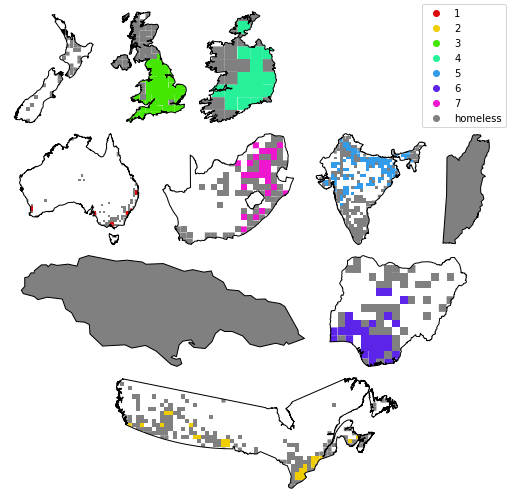

In [126]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1,
                               save_path_fmt=paths.cluster_fig_fmt)

In [430]:
dbscan_params = {'eps': 3, 'min_samples': 10, 'metric': 'cosine'}
db = sklearn.cluster.DBSCAN(**dbscan_params).fit(proj_vectors)
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
print(n_clusters, n_noise)

9 2511


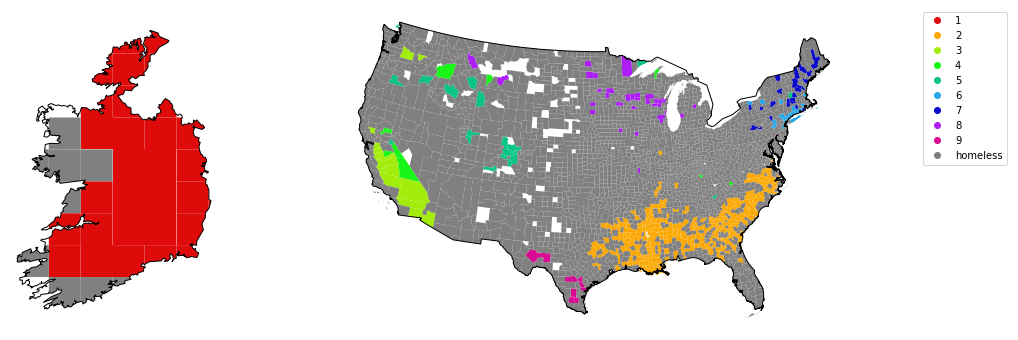

In [431]:
cmap = None #'Dark2'
fig, axes = map_viz.joint_cc(
    cells_geodf.loc[relevant_cells], db.labels_, data_dict, cmap=cmap, show=True,
    figsize=(18,6), gridspec_kw={'width_ratios': width_ratios})

In [167]:
dbscan_params = {'eps': 0.06, 'min_samples': 3, 'metric': 'cosine'}
db = sklearn.cluster.DBSCAN(**dbscan_params).fit(proj_vectors)
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
print(n_clusters, n_noise)

6 90


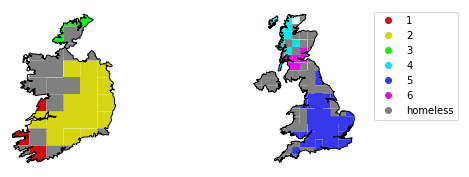

In [169]:
cmap = None
fig, axes = map_viz.joint_cc(
    cells_geodf.loc[relevant_cells], db.labels_, data_dict, cmap=cmap, show=True,
    figsize=(9,3), gridspec_kw={'width_ratios': width_ratios})

In [117]:
opt_params = {'min_samples': 10, 'xi': 0.1, 'min_cluster_size': 5,
              'metric': 'euclidean'}
method = sklearn.cluster.OPTICS
clustering = lang.decompositions[-1].add_clustering(
    method, lang.relevant_cells, append=False, **opt_params)

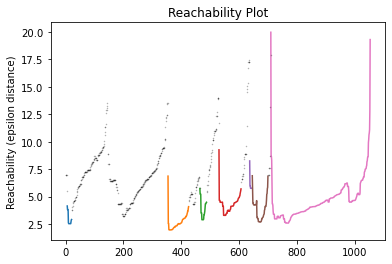

In [118]:
fig, ax = clustering.reach_plot()

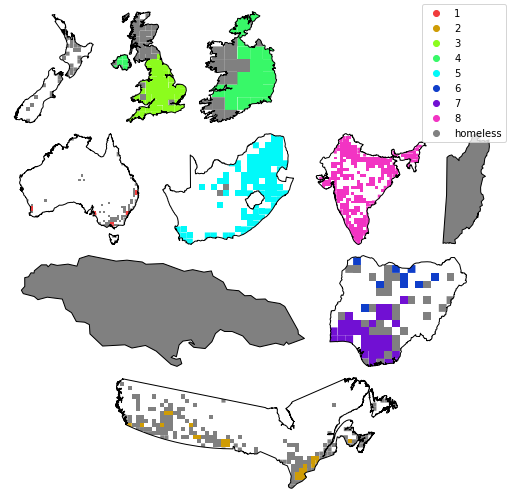

In [116]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1)

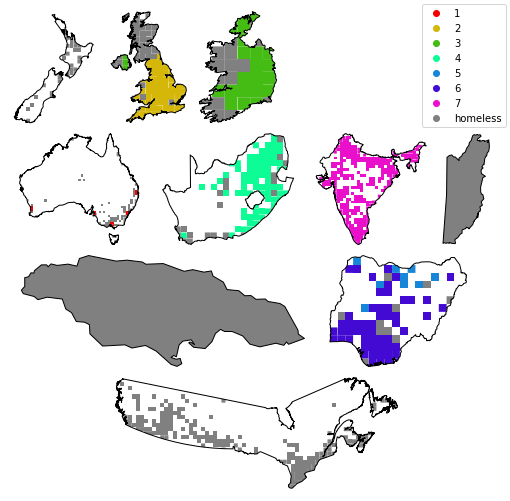

In [102]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-2,
                               save_path_fmt=paths.cluster_fig_fmt)

## Graph

In [50]:
net_file_path_fmt = paths.processed_data / 'oslom_net_metric={metric}_transfo={transfo_str}.dat'
metric = 'cosine'
transfo = None
oslom_opt_params = ['-singlet'] #, '-r', '50']
decompo = lang.decompositions[-1]

In [51]:
args, kwargs = decompo.prep_oslom(metric, net_file_path_fmt, transfo=transfo,
                                  oslom_opt_params=oslom_opt_params)
data_clustering.run_oslom(*args, **kwargs)

In [137]:
decompo.add_oslom_hierarchy(
    metric, net_file_path_fmt, lang.relevant_cells, transfo=transfo,
    oslom_opt_params=oslom_opt_params)

- level 0


HierarchicalClustering(levels=[Clustering(method_repr='oslom', method_obj=None, method_args=None, method_kwargs=None, nr_clusters=1, prop_homeless=1.0, kwargs_str='-singlet')], method_repr='oslom', method_args=None, method_kwargs=None, kwargs_str='-singlet')

TODO afterards: SBM

`2*arctanh(1-correlation)` (and `2*arctanh(1-cosine))`) into SBM with rec_types=["real-normal"]

log(euclidean) into SBM with rec_types=["real-normal"]

# Overlap between clusterings

In [191]:
import sklearn.metrics

In [265]:
clust1_labels = clusts[-1].clusters_series.values.astype(int)
clust2_labels = clusts[0].levels[1].clusters_series.values.astype(int)

print(sklearn.metrics.adjusted_mutual_info_score(clust1_labels, clust2_labels),
      sklearn.metrics.adjusted_rand_score(clust1_labels, clust2_labels),
      sklearn.metrics.rand_score(clust1_labels, clust2_labels))

0.7549827526928913 0.6835948082062118 0.8530506718085932


pb: Jaccard sensitive to cluster nr permutations...

In [306]:
m1 = clusts[-1].get_binary_matrix()
m2 = clusts[0].levels[1].get_binary_matrix(other_matrix=m1)

1 0


In [308]:
print(
    sklearn.metrics.jaccard_score(m1, m2, average='weighted'),
    sklearn.metrics.jaccard_score(m1, m2, average='samples'))

0.7646259443523126 0.8641975308641975


In [312]:
sklearn.metrics.jaccard_score(m1, m2, average='micro')

0.7608695652173914

# Get words characteristic of each cluster

In [152]:
decomp = lang.decompositions[-1]
cluster_labels = decomp.clusterings[-1].clusters_series
is_regional = ((lang.global_counts['z_value'] > lang.z_th)
              & (lang.global_counts['p_value'] < lang.p_th))
a = lang.global_counts.loc[is_regional].copy()
comps = decomp.decomposition.components_
for i in np.unique(cluster_labels):
    clust_center = decomp.proj_vectors[cluster_labels == i, :].mean(axis=0)
    words_cluster = np.dot(comps.T, clust_center)
#     words_cluster = comps[0, :] * clust_center[0]
#     for comp, cent in zip(comps[1:, :], clust_center[1:]):
#         words_cluster += comp*cent
    a[f'cluster{i}'] = words_cluster

In [150]:
a.sort_values(by='cluster3', key=np.abs, ascending=False).head(20)

,count,is_proper,nr_cells,I,z_value,p_value,cdf_mask,cluster1,cluster2,cluster3
word,,,,,,,,,,
crore,110054.0,0.0,654.959972,1.012907,44.361407,0.001,True,-0.580421,-0.576850,1.192194
lakh,91236.0,0.0,650.677872,1.013164,43.919454,0.001,True,-0.579147,-0.575476,1.189456
rupees,27984.0,0.0,652.528287,0.999763,42.069054,0.001,True,-0.587121,-0.563308,1.182879
crores,65295.0,0.0,588.794336,1.010227,44.517461,0.001,True,-0.573560,-0.571892,1.180228
caste,68296.0,0.0,758.984118,0.997013,44.508197,0.001,True,-0.577361,-0.533938,1.140359
bhi,219342.0,0.0,762.215323,0.990518,42.331164,0.001,True,-0.533369,-0.533981,1.099998
devotees,20039.0,0.0,614.511252,0.944141,41.359610,0.001,True,-0.567432,-0.498292,1.090516
raha,56178.0,0.0,637.124241,0.971633,41.545353,0.001,True,-0.526894,-0.529286,1.088686
secularism,30581.0,0.0,629.247665,0.964517,42.262670,0.001,True,-0.579845,-0.486594,1.088554


In [67]:
a.sort_values(by='cluster3', key=np.abs, ascending=False).head(20)

,count,is_proper,nr_cells,I,z_value,p_value,cdf_mask,cluster1,cluster2,cluster3
word,,,,,,,,,,
kwa,23016.0,0.0,339.318615,0.889178,39.479243,0.001,True,-0.242379,-0.225497,1.135619
tweep,14246.0,0.0,450.336169,0.724595,31.666589,0.001,True,-0.202901,-0.266385,1.098167
nigga,476122.0,0.0,1015.261979,0.897150,39.375809,0.001,True,-0.141347,-0.356817,1.090477
stingy,23458.0,0.0,549.724349,0.796824,35.309292,0.001,True,-0.136963,-0.358735,1.081335
hustling,19974.0,0.0,588.678416,0.703231,29.704741,0.001,True,-0.201704,-0.255324,1.073654
mahn,26059.0,0.0,421.246039,0.777674,33.412345,0.001,True,-0.268552,-0.149087,1.066749
ddnt,11048.0,0.0,330.864902,0.759791,32.804352,0.001,True,-0.218811,-0.221139,1.058585
airtime,74566.0,0.0,910.775666,0.790693,34.759536,0.001,True,-0.224477,-0.202190,1.039100
niggas,267470.0,0.0,810.790865,0.885800,38.477584,0.001,True,-0.135470,-0.338679,1.038861
